# this notebook parse patch data
# TODO: meet with Venu to confirm the changes I made
# TODO: figure out the units in COSMED

In [1]:
import numpy as np
import argparse
import numba as nb
from numpy_ext import rolling_apply

import json
import os
import math
from math import sin

import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns


import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
# %matplotlib inline

i_seed = 0

import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from filters import *
from setting import *
from plotting_tools import *
from stage1_patch import *
from TimeStampReader import *
from stage1_cosmed import *
from PatchParser import *
from stage3_inspection import *


from importlib import reload
%load_ext autoreload
%autoreload 2

In [2]:
parser = argparse.ArgumentParser(description='SpO2_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--subject_id', metavar='subject_id', help='subject_id',
                    default='101')
parser.add_argument('--cosmed_unfiltered', metavar='cosmed_unfiltered', help='cosmed_unfiltered',
                    default='False')
parser.add_argument('--saving_format', metavar='saving_format', help='saving_format',
                    default='feather')



# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../../data/stage1/', 
                          '--output_folder', '../../data/stage2/',
                          '--subject_id', 'sub118',
                          '--cosmed_unfiltered', 'False',
                          '--saving_format', 'csv',
                         ])
# args = parser.parse_args()
print(args)

Namespace(cosmed_unfiltered='False', input_folder='../../data/stage1/', output_folder='../../data/stage2/', saving_format='feather', subject_id='sub113')


In [3]:
# args.cosmed_unfiltered

In [4]:
inputdir = args.input_folder
outputdir = args.output_folder
subject_id = args.subject_id
saving_format = args.saving_format

if args.cosmed_unfiltered == 'True':
     cosmed_unfiltered = True
elif args.cosmed_unfiltered == 'False':
     cosmed_unfiltered = False
        
        
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
outputdir_sub = outputdir+subject_id+'/'

if cosmed_unfiltered:
    outputdir_sub = outputdir_sub+'cosmed_unfiltered/'

if not os.path.exists(outputdir_sub):
    os.makedirs(outputdir_sub)

# get cosmed data

In [5]:
outputdir_sub

'../../data/stage2/sub113/'

In [6]:
if cosmed_unfiltered:
    obj_cosmed = load_sub(inputdir+subject_id+'/cosmed_unfiltered/data')
else:
    obj_cosmed = load_sub(inputdir+subject_id+'/cosmed/data')



In [7]:
# obj_cosmed.task_ts_dict

In [8]:
with open('subject_patch_dict.json') as json_file:
    subject_patch_dict = json.load(json_file)[0]

In [9]:
# subject_patch_dict = {}
# for i in range(0,26):
    
#     subject_patch_dict['sub{}'.format(i+101)] = 'sternum'
    
#     if i==5:
#          subject_patch_dict['sub{}'.format(i+101)] = 'clavicle'
#     if i==8:
#          subject_patch_dict['sub{}'.format(i+101)] = 'ribcage'
#     if i==9:
#          subject_patch_dict['sub{}'.format(i+101)] = 'ribcage'
#     if i==17:
#          subject_patch_dict['sub{}'.format(i+101)] = 'ribcage' # or clavicle

In [10]:
subject_patch_dict

{'sub101': 'sternum',
 'sub102': 'sternum',
 'sub103': 'sternum',
 'sub104': 'sternum',
 'sub105': 'clavicle',
 'sub106': 'sternum',
 'sub107': 'sternum',
 'sub108': 'ribcage',
 'sub109': 'ribcage',
 'sub110': 'sternum',
 'sub111': 'sternum',
 'sub112': 'sternum',
 'sub113': 'sternum',
 'sub114': 'sternum',
 'sub115': 'sternum',
 'sub116': 'sternum',
 'sub117': 'ribcage',
 'sub118': 'sternum',
 'sub119': 'sternum',
 'sub120': 'sternum',
 'sub121': 'sternum',
 'sub122': 'sternum',
 'sub123': 'sternum',
 'sub124': 'sternum',
 'sub125': 'sternum',
 'sub212': 'sternum'}

# get sternum patch data
# if subject_patch_dict[subject_id]!='sternum', will transplant the ECG from other location. Other signals will remain chest-based
## these subjects include 105, 108, 109, 117

In [11]:
if subject_patch_dict[subject_id]!='sternum':
    print('transplanting for {}...'.format(subject_id))
    df_patch_ecg = pd.read_feather(inputdir+subject_id + '/patch/df_patch_{}.feather'.format(subject_patch_dict[subject_id]))

    df_patch = pd.read_feather(inputdir+subject_id + '/patch/df_patch_{}.feather'.format('sternum'))

    TMAX = min([df_patch_ecg['time'].max(), df_patch['time'].max()])
    TMIN = max([df_patch_ecg['time'].min(), df_patch['time'].min()])

    df_patch = df_patch[(df_patch['time']>=TMIN) & (df_patch['time']<=TMAX)]
    df_patch_ecg = df_patch_ecg[(df_patch_ecg['time']>=TMIN) & (df_patch_ecg['time']<=TMAX)]
    
#     ecg_prosthetic = df_patch_ecg['ECG'].values
    ecg_prosthetic = np.interp(df_patch['time'].values, df_patch_ecg['time'].values, df_patch_ecg['ECG'].values)
    df_patch['ECG'] = ecg_prosthetic
    
    del df_patch_ecg
    del ecg_prosthetic
    
else:
    df_patch = pd.read_feather(inputdir+subject_id + '/patch/df_patch_{}.feather'.format(subject_patch_dict[subject_id]))

In [12]:
# time_interp = np.arange(my_ceil(-1215.51312, decimal=-3)*FS_RESAMPLE, my_floor(5883.236, decimal=-3)*FS_RESAMPLE+1)/FS_RESAMPLE

# time_interp

# COSMED label correction (manually determine how much the delay is)

## currently, we only have to do it for sub101 (sync between the cosmed and the patch has delay since the emergence of cosemd marker is late)

In [13]:
if subject_id =='sub101':
    cosmed_mark_delay_patch_taps_by = 13
else:
    cosmed_mark_delay_patch_taps_by = 0
    
if cosmed_mark_delay_patch_taps_by!= 0:
    df_patch['time'] =  df_patch['time']-cosmed_mark_delay_patch_taps_by

# inspect the patch data, 50s before and after 1st 6MWT

In [14]:
def inspect_patch2(df_patch, subject_id, title_str, VIS_START = 200, VIS_END = 230, outputdir=None, show_plot=False):

    t_arr = df_patch['time']
    t_mask = (t_arr>=VIS_START) & (t_arr<VIS_END)
    
    df_patch = df_patch[t_mask]
    t_arr = df_patch['time'].values

    
#     for key in data_dict:
#         if key != 'subject_id':
#             data_dict[key] = data_dict[t_mask]
    
    t_dur = df_patch['time'].values[-1] - df_patch['time'].values[0]

    print('[{}]: {} sec'.format(subject_id, t_dur))

#     t_arr =  df_patch['time']

    # fig = plt.figure(figsize=(3*t_dur/80, 3*10), dpi=50, facecolor='white')
    fig = plt.figure(figsize=(20, 10), dpi=80, facecolor='white')

    fontsize = 15
    scale_factor = 8
    alpha = 0.8

    ax1 = fig.add_subplot(4,1,1)
    ax1.plot(t_arr, df_patch['ECG'].values, color=color_dict[sync_color_dict['ECG']], alpha=0.5 ,zorder=1)

    ax1.set_xlim(t_arr[0],t_arr[-1])
    ax1.set_title(title_str + 'ECG', fontsize=fontsize)
    ax1.set_ylabel('a.u.', fontsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)


    ax2 = fig.add_subplot(4,1,2)
    ax2.plot(t_arr, df_patch['accelX'].values, color=color_dict[sync_color_dict['accelX']], alpha=alpha ,zorder=1, label='accelX')
    ax2.plot(t_arr, df_patch['accelY'].values, color=color_dict[sync_color_dict['accelY']], alpha=alpha ,zorder=1, label='accelY')
    ax2.plot(t_arr, df_patch['accelZ'].values, color=color_dict[sync_color_dict['accelZ']], alpha=alpha ,zorder=1, label='accelZ')
    ax2.set_xlim(t_arr[0],t_arr[-1])
    ax2.set_title(title_str + 'ACC', fontsize=fontsize)
    ax2.set_ylabel('a.u.', fontsize=fontsize)
    ax2.tick_params(axis='x', labelsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)
    ax2.legend(loc='upper left', fontsize=fontsize, frameon=True)

    ax3 = fig.add_subplot(4,1,3)
    ax3.plot(t_arr, df_patch['ppg_g_1'].values, color=color_dict[sync_color_dict['ppg_g_1']], alpha=alpha ,zorder=1, label='ppg_g_1')
    ax3.plot(t_arr, df_patch['ppg_r_1'].values, color=color_dict[sync_color_dict['ppg_r_1']], alpha=alpha ,zorder=1, label='ppg_r_1')
    ax3.plot(t_arr, df_patch['ppg_ir_1'].values, color=color_dict[sync_color_dict['ppg_ir_1']], alpha=alpha ,zorder=1, label='ppg_ir_1')
    ax3.set_xlim(t_arr[0],t_arr[-1])
    ax3.set_title(title_str + 'PPG arr 1', fontsize=fontsize)
    ax3.set_ylabel('ppg intensity (uA)', fontsize=fontsize)
    ax3.tick_params(axis='x', labelsize=fontsize)
    ax3.tick_params(axis='y', labelsize=fontsize)
    ax3.legend(loc='upper left', fontsize=fontsize, frameon=True)

    ax4 = fig.add_subplot(4,1,4)
    ax4.plot(t_arr, df_patch['ppg_g_2'].values, color=color_dict[sync_color_dict['ppg_g_2']], alpha=alpha ,zorder=1, label='ppg_g_2')
    ax4.plot(t_arr, df_patch['ppg_r_2'].values, color=color_dict[sync_color_dict['ppg_r_2']], alpha=alpha ,zorder=1, label='ppg_r_2')
    ax4.plot(t_arr, df_patch['ppg_ir_2'].values, color=color_dict[sync_color_dict['ppg_ir_2']], alpha=alpha ,zorder=1, label='ppg_ir_2')
    ax4.set_xlim(t_arr[0],t_arr[-1])
    ax4.set_title(title_str + 'PPG arr 2', fontsize=fontsize)
    ax4.set_ylabel('ppg intensity (uA)', fontsize=fontsize)
    ax4.tick_params(axis='x', labelsize=fontsize)
    ax4.tick_params(axis='y', labelsize=fontsize)
    ax4.legend(loc='upper left', fontsize=fontsize, frameon=True)


    ax4.set_xlabel('time (sec)', fontsize=fontsize)

    fig.tight_layout()
    
#     fig_name = '{}_signl_{}'.format(title_str,subject_id)
    fig_name = '{}_signl_{}'.format(title_str,subject_id)

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + fig_name + '.png', facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')

In [15]:
print('3 taps starts at: {}s'.format ( obj_cosmed.task_ts_dict['3 Taps 0'] ))

3 taps starts at: 0.0s


In [16]:
inpsect_sigs = False
if inpsect_sigs:

#     VIS_START = obj_cosmed.task_ts_dict['Start 6MWT 0']-50
#     VIS_END = obj_cosmed.task_ts_dict['End 6MWT 0']+50
    VIS_START = obj_cosmed.task_ts_dict['Start 6MWT-R 0']-50
    VIS_END = obj_cosmed.task_ts_dict['End Run 0']+50

    inspect_patch2(df_patch, subject_id, title_str='raw', VIS_START=VIS_START, VIS_END=VIS_END, show_plot=True)

In [17]:
# for key in df_patch:
#     print(key)

# get df_cosmed

In [18]:
df_cosmed = obj_cosmed.df_data
df_cosmed


24,time(s),Marker,HR,RR,VT,VE,FeO2,FeCO2,FiO2,FiCO2,VO2,VCO2,EE,SPO2,GpsAlt,AmbTemp,Battery,K5_R,task
0,-137.0,0.0,95.0,8.020000,1808.2,10100.0,17.590,3.642,20.93,0.04,280.8,301.8,1.441350,96.8,322.0,23.4,92.0,1.122,Nan
1,-127.0,0.0,94.4,8.020000,1708.6,10420.0,17.482,3.646,20.93,0.04,297.8,310.6,1.518098,96.8,320.0,23.4,92.0,1.076,Nan
2,-119.0,0.0,93.6,7.860000,1484.6,9280.0,17.284,3.586,20.93,0.04,276.2,278.6,1.397474,96.8,317.0,23.4,92.0,0.982,Nan
3,-101.0,0.0,94.2,7.260000,1194.2,7900.0,17.318,3.328,20.93,0.04,245.2,239.6,1.232044,96.4,310.0,23.4,92.0,0.886,Nan
4,-97.0,0.0,94.8,7.200741,1153.6,7320.0,17.150,3.316,20.93,0.04,245.6,221.2,1.213196,95.8,310.0,23.4,92.0,0.842,Nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,4341.0,0.0,115.8,15.640000,2653.0,41400.0,18.152,4.602,20.93,0.04,765.8,1520.2,4.704674,96.0,313.0,5.6,67.0,1.992,Nan
795,4344.0,0.0,116.4,19.680000,2526.2,47600.0,18.256,4.462,20.93,0.04,840.8,1691.8,5.190650,96.0,315.0,5.6,67.0,2.016,Nan
796,4348.0,0.0,117.2,21.960000,2330.8,48820.0,18.388,4.312,20.93,0.04,816.6,1682.0,5.084424,96.0,316.0,6.5,67.0,2.064,Nan
797,4350.0,0.0,118.0,24.020000,2096.2,48780.0,18.472,4.224,20.93,0.04,783.4,1646.2,4.913878,96.0,316.0,6.6,67.0,2.102,Nan


# get time vectors of both patch and cosmed

In [19]:
t_patch = df_patch['time'].values
t_cosmed = df_cosmed['time(s)'].values


# create t_sync (cosmed and patch will share this t vector)

In [20]:
# t=0 is 3 taps
t_study_start = 0

# the last timestamp that is not equal to Nan
t_study_end = df_cosmed[df_cosmed['task']!='Nan']['time(s)'].max()

t_sync = t_patch[(t_patch>=t_study_start) & (t_patch<=t_study_end)]

# resample cosmed data so its time vector is now t_sync

In [21]:
cosmed_resampled = {}


for cosmed_label in list(df_cosmed.columns):
    
    if cosmed_label in ['time(s)', 'task', 'Marker']:
        continue
        
    v_cosmed_label = df_cosmed[cosmed_label].values
    t_cosmed = df_cosmed['time(s)'].values

    v_cosmed_label_sync = np.interp(t_sync, t_cosmed, v_cosmed_label)
    cosmed_resampled[cosmed_label+'_cosmed'] = v_cosmed_label_sync


In [22]:
cosmed_resampled['time'] = t_sync

# create an equally long Marker vector

In [23]:
v_cosmed_Marker = np.zeros(t_sync.shape[0])
t_markers = df_cosmed[df_cosmed['Marker']==1]['time(s)'].values
for t_marker in t_markers:
    i_min = np.argmin(np.abs(t_sync-t_marker))
    v_cosmed_Marker[i_min] = 1
    
cosmed_resampled['Marker_cosmed'] = v_cosmed_Marker


In [24]:
# obj_cosmed.task_ts_dict

# create an equally long task vector
## for outdoor walk, start from `Start Walk 0` till `Start Stair 1`

In [25]:
# FS_tasks


In [26]:
# obj_cosmed.task_ts_dict

In [27]:
# task_ts_dict = obj_cosmed.task_ts_dict

# for task_name in task_ts_dict:
#     if 'Stair' in task_name:
#         print('{}\t\t{:.2f}s'.format(task_name, task_ts_dict[task_name]) )
# # 'Bottom Stair 0' in task_ts_dict

In [1]:
# task_ts_dict = obj_cosmed.task_ts_dict

# for task_name in task_ts_dict:
#     if 'Stair' in task_name:
#         print('{}\t\t{:.2f}s'.format(task_name, task_ts_dict[task_name]) )
# # 'Bottom Stair 0' in task_ts_dict

In [29]:
# if subject_id=='sub104':
    
#     t_SB = task_ts_dict['Stair Bottom 0']
#     t_ST = task_ts_dict['Stair Top 0']
    
#     task_ts_dict['Stair Bottom 0'] = t_ST
#     task_ts_dict['Stair Top 0'] = t_SB

In [30]:
v_cosmed_task = np.asarray(['Transition']*t_sync.shape[0], dtype=object)

task_ts_dict = obj_cosmed.task_ts_dict

for task_name in FS_tasks:
    print(task_name)
    task_start = 'Start ' + task_name
    task_end = 'End ' + task_name
    
    if 'Stair' not in task_name:
        if task_start not in task_ts_dict:
            print('{} not in task_ts_dict'.format(task_name))
            continue
            
        t_start =  task_ts_dict[task_start]
        t_end =  task_ts_dict[task_end]
    
    if task_name == 'Walk 0':
        t_stair2rest = 70
        
        print('\tUsing ==Start Walk 0== till ==Start Stair 1== for ====={}====='.format(task_name))
        print('\t ==Start Walk 0== till ==End Walk 0==: {:.2f} sec'.format( t_end-t_start ) )
        t_start =  task_ts_dict['Start Walk 0']
        if 'Start Stair 1' in task_ts_dict:
            t_end =  task_ts_dict['Start Stair 1']
#             t_end =  task_ts_dict['End Walk 0']
            print('\t ==Start Walk 0== till ==Start Stair 1==: {:.2f} sec'.format( t_end-t_start ) )
        else:
            t_end =  task_ts_dict['End Walk 0'] - t_stair2rest # remove the last 70s
            print('\t ==Start Walk 0== till ==End Walk 0 - {:.2f} sec==: {:.2f} sec'.format( t_stair2rest, t_end-t_start ) )

        
        
        
    if task_name == 'StairDown0':
        t_start =  task_ts_dict['Start Stair 0']
                
        if 'Stair Bottom 0' in task_ts_dict:
            t_end =  task_ts_dict['Stair Bottom 0']
        elif 'Bottom Stair 0' in task_ts_dict:
            t_end =  task_ts_dict['Bottom Stair 0']

        print('\t ===={}====: {:.2f} sec'.format( task_name, t_end-t_start ) )
        
    if task_name == 'StairUp0':
#         t_start =  task_ts_dict['Stair Bottom 0']
#         t_end =  task_ts_dict['Stair Top 0']

        if 'Stair Bottom 0' in task_ts_dict:
            t_start =  task_ts_dict['Stair Bottom 0']
        elif 'Bottom Stair 0' in task_ts_dict:
            t_start =  task_ts_dict['Bottom Stair 0']
            
        if 'Stair Top 0' in task_ts_dict:
            t_end =  task_ts_dict['Stair Top 0']
        elif 'Top Stair 0' in task_ts_dict:
            t_end =  task_ts_dict['Top Stair 0']
            
        print('\t ===={}====: {:.2f} sec'.format( task_name, t_end-t_start ) )
        
                
    if task_name == 'StairDown1':
#         t_start =  task_ts_dict['Stair Top 0']
        if 'Stair Top 0' in task_ts_dict:
            t_start =  task_ts_dict['Stair Top 0']
        elif 'Top Stair 0' in task_ts_dict:
            t_start =  task_ts_dict['Top Stair 0']
        t_end =  task_ts_dict['End Stair 0']
        print('\t ===={}====: {:.2f} sec'.format( task_name, t_end-t_start ) )
        
        
        
        
        

    
    task_mask = (t_sync>=t_start) & (t_sync<t_end)
    v_cosmed_task[task_mask] = task_name
    
cosmed_resampled['task'] = v_cosmed_task


Baseline 0
Standing 0
Proning 0
LL 0
LR 0
Cough 0
SpeakCasual 0
SpeakScripted 0
6MWT 0
Recovery 0
6MWT-R 0
Recovery 1
StairDown0
	 ====StairDown0====: 34.83 sec
StairUp0
	 ====StairUp0====: 57.03 sec
StairDown1
	 ====StairDown1====: 18.79 sec
Recovery 2
Cough 1
SpeakCasual 1
SpeakScripted 1
Walk 0
	Using ==Start Walk 0== till ==Start Stair 1== for =====Walk 0=====
	 ==Start Walk 0== till ==End Walk 0==: 389.57 sec
	 ==Start Walk 0== till ==Start Stair 1==: 389.57 sec
Recovery 3
Run 0
Recovery 4
Exhaustion 0
Exhaustion 0 not in task_ts_dict
Recovery 5
Recovery 5 not in task_ts_dict
Exhaustion 1
Exhaustion 1 not in task_ts_dict
Recovery 6
Recovery 6 not in task_ts_dict


In [31]:
# task_ts_dict

In [32]:
# np.unique(cosmed_resampled['task'])

# create an equally long Sample vector (to record when cosmed makes an sample)

In [33]:
v_cosmed_sampled = np.zeros(t_sync.shape[0])


## time consuming, consider replacing argmin with something else

In [34]:
# indices_mask[0].shape, t_cosmed.shape

In [35]:
t_cosmed = df_cosmed['time(s)'].values

cosmed_label = 'RR'
v_cosmed_label = df_cosmed[cosmed_label].values

# if RR values are wrong, discard it completely
indices_mask = np.where((v_cosmed_label>=label_range_dict[cosmed_label][0]) & (v_cosmed_label<=label_range_dict[cosmed_label][1]))
t_cosmed = t_cosmed[indices_mask]

for t in t_cosmed:
    i_min = np.argmin( np.abs(t - t_sync) )

    v_cosmed_sampled[i_min] = 1

cosmed_resampled['Sampled_cosmed'] = v_cosmed_sampled


# patch and cosmed data are sync!

In [36]:
df_sync = pd.DataFrame.from_dict(cosmed_resampled)


In [37]:
# df_sync[df_sync['task']=='Walk 0']['time'].min(), df_sync[df_sync['task']=='Walk 0']['time'].max()

In [38]:
# df_sync[df_sync['task']=='Stair 1']['time'].min(), df_sync[df_sync['task']=='Stair 1']['time'].max()

In [39]:
# for key in cosmed_resampled:
#     print(cosmed_resampled[key].shape)

In [40]:
df_sync['task'].unique()

array(['Transition', 'Baseline 0', 'Standing 0', 'Proning 0', 'LL 0',
       'LR 0', 'Cough 0', 'SpeakCasual 0', 'SpeakScripted 0', '6MWT-R 0',
       'Recovery 0', '6MWT 0', 'Recovery 1', 'StairDown0', 'StairUp0',
       'StairDown1', 'Recovery 2', 'Cough 1', 'SpeakCasual 1',
       'SpeakScripted 1', 'Walk 0', 'Recovery 3', 'Run 0', 'Recovery 4'],
      dtype=object)

In [41]:
t_patch = df_patch['time'].values
df_patch_sync = df_patch[(t_patch>=t_study_start) & (t_patch<=t_study_end)]
# df_patch_sync = df_patch_sync.drop(columns=['HR_cosmed'])
df_patch_sync

,ECG,accelX,accelY,accelZ,ppg_g_1,ppg_r_1,ppg_ir_1,ppg_g_2,ppg_r_2,ppg_ir_2,temp_skin,pres,time
370931,0.181235,-0.023083,0.956833,0.560182,25445.247272,911.753375,15790.133395,22105.693503,5195.016624,14636.500687,33.74500,987.071153,0.004
370932,0.178968,-0.163255,0.690645,-1.134039,25450.513616,912.011188,15792.434647,22107.006539,5195.371073,14637.166694,33.74500,987.071149,0.008
370933,0.163414,-0.261230,0.762804,-1.319421,25461.112321,912.991473,15799.177618,22113.276643,5196.614361,14640.502185,33.74500,987.071144,0.012
370934,0.162777,-0.008619,1.087002,1.119775,25471.711026,913.971758,15805.920590,22119.546748,5197.857650,14643.837676,33.74500,987.071140,0.016
370935,0.194589,0.140646,1.155359,1.237694,25482.309730,914.952044,15812.663561,22125.816853,5199.100938,14647.173168,33.74500,987.071135,0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455176,-0.812126,0.018538,0.991982,0.045998,25348.809086,594.529543,14689.743967,21384.342279,3525.238909,13648.871352,32.91897,986.810721,4336.984
1455177,-0.811696,0.017375,0.990498,0.042480,25346.386056,594.142751,14687.734467,21382.615869,3522.690630,13647.409897,32.91901,986.810706,4336.988
1455178,-0.818481,0.019022,0.984877,0.039504,25343.963025,593.755958,14685.724967,21380.889460,3520.142351,13645.948443,32.91905,986.810691,4336.992
1455179,-0.821360,0.021566,0.979155,0.039410,25341.539995,593.369166,14683.715467,21379.163051,3517.594072,13644.486988,32.91909,986.810675,4336.996


In [42]:
df_sync  = pd.merge(df_sync, df_patch_sync, on="time")

In [43]:
df_sync

,HR_cosmed,RR_cosmed,VT_cosmed,VE_cosmed,FeO2_cosmed,FeCO2_cosmed,FiO2_cosmed,FiCO2_cosmed,VO2_cosmed,VCO2_cosmed,EE_cosmed,SPO2_cosmed,GpsAlt_cosmed,AmbTemp_cosmed,Battery_cosmed,K5_R_cosmed,time,Marker_cosmed,task,Sampled_cosmed,ECG,accelX,accelY,accelZ,ppg_g_1,ppg_r_1,ppg_ir_1,ppg_g_2,ppg_r_2,ppg_ir_2,temp_skin,pres
0,98.40208,10.779376,2095.11376,22339.664,17.196090,3.864050,20.93,0.04,667.36736,689.1976,3.394437,97.20032,331.000,23.5000,91.0,1.040046,0.004,1.0,Transition,1.0,0.181235,-0.023083,0.956833,0.560182,25445.247272,911.753375,15790.133395,22105.693503,5195.016624,14636.500687,33.74500,987.071153
1,98.40416,10.778752,2095.22752,22339.328,17.196179,3.864099,20.93,0.04,667.33472,689.1952,3.394305,97.20064,331.000,23.5000,91.0,1.040093,0.008,0.0,Transition,0.0,0.178968,-0.163255,0.690645,-1.134039,25450.513616,912.011188,15792.434647,22107.006539,5195.371073,14637.166694,33.74500,987.071149
2,98.40624,10.778128,2095.34128,22338.992,17.196269,3.864149,20.93,0.04,667.30208,689.1928,3.394174,97.20096,331.000,23.5000,91.0,1.040139,0.012,0.0,Transition,0.0,0.163414,-0.261230,0.762804,-1.319421,25461.112321,912.991473,15799.177618,22113.276643,5196.614361,14640.502185,33.74500,987.071144
3,98.40832,10.777504,2095.45504,22338.656,17.196358,3.864198,20.93,0.04,667.26944,689.1904,3.394043,97.20128,331.000,23.5000,91.0,1.040186,0.016,0.0,Transition,0.0,0.162777,-0.008619,1.087002,1.119775,25471.711026,913.971758,15805.920590,22119.546748,5197.857650,14643.837676,33.74500,987.071140
4,98.41040,10.776880,2095.56880,22338.320,17.196448,3.864248,20.93,0.04,667.23680,689.1880,3.393912,97.20160,331.000,23.5000,91.0,1.040232,0.020,0.0,Transition,0.0,0.194589,0.140646,1.155359,1.237694,25482.309730,914.952044,15812.663561,22125.816853,5199.100938,14647.173168,33.74500,987.071135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084245,115.39840,16.456800,2650.09040,43393.680,18.087848,4.684216,20.93,0.04,817.94320,1614.2600,5.014525,96.00000,312.996,6.4968,67.0,1.971976,4336.984,0.0,Recovery 4,0.0,-0.812126,0.018538,0.991982,0.045998,25348.809086,594.529543,14689.743967,21384.342279,3525.238909,13648.871352,32.91897,986.810721
1084246,115.39880,16.457600,2650.06780,43395.260,18.087886,4.684162,20.93,0.04,817.95740,1614.2950,5.014620,96.00000,312.997,6.4976,67.0,1.971982,4336.988,0.0,Recovery 4,0.0,-0.811696,0.017375,0.990498,0.042480,25346.386056,594.142751,14687.734467,21382.615869,3522.690630,13647.409897,32.91901,986.810706
1084247,115.39920,16.458400,2650.04520,43396.840,18.087924,4.684108,20.93,0.04,817.97160,1614.3300,5.014714,96.00000,312.998,6.4984,67.0,1.971988,4336.992,0.0,Recovery 4,0.0,-0.818481,0.019022,0.984877,0.039504,25343.963025,593.755958,14685.724967,21380.889460,3520.142351,13645.948443,32.91905,986.810691
1084248,115.39960,16.459200,2650.02260,43398.420,18.087962,4.684054,20.93,0.04,817.98580,1614.3650,5.014809,96.00000,312.999,6.4992,67.0,1.971994,4336.996,0.0,Recovery 4,0.0,-0.821360,0.021566,0.979155,0.039410,25341.539995,593.369166,14683.715467,21379.163051,3517.594072,13644.486988,32.91909,986.810675


In [44]:
# plt.plot(df_sync['task'])

In [45]:
df_sync['task'].unique()

array(['Transition', 'Baseline 0', 'Standing 0', 'Proning 0', 'LL 0',
       'LR 0', 'Cough 0', 'SpeakCasual 0', 'SpeakScripted 0', '6MWT-R 0',
       'Recovery 0', '6MWT 0', 'Recovery 1', 'StairDown0', 'StairUp0',
       'StairDown1', 'Recovery 2', 'Cough 1', 'SpeakCasual 1',
       'SpeakScripted 1', 'Walk 0', 'Recovery 3', 'Run 0', 'Recovery 4'],
      dtype=object)

In [46]:
def check_walk(df_sync, task_name='Walk 0', fig_name=None, outputdir=None, show_plot=False):
    df = df_sync[df_sync['task']==task_name]
    t_vector = df['time'].values
    t_vector = t_vector-t_vector.min()
    
    fig, axes = plt.subplots(3,1, figsize=(100,6), dpi=120,  facecolor='white')

    for i, sig_name in enumerate(['accelX', 'accelY', 'accelZ']):
        ax = axes[i]
        ax.plot(t_vector[::15], df[sig_name].values[::15])
        ax.set_xlim(t_vector.min(),t_vector.max())
        ax_no_top_right(ax)

    ax.set_xlabel('time (s)')

    fig.tight_layout()
    plt.show()
    
    if fig_name is None:
        fig_name = 'ACC_Walk0'

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + fig_name + '.png', facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')

In [63]:
# # df = df_sync[df_sync['task']=='StairDown1']
# df = df_sync[df_sync['task']=='Walk 0']

In [59]:
# df_sync['task'].unique()

In [62]:
# plt.plot(df['pres'].values)
# plt.show()

In [65]:
# subject_id

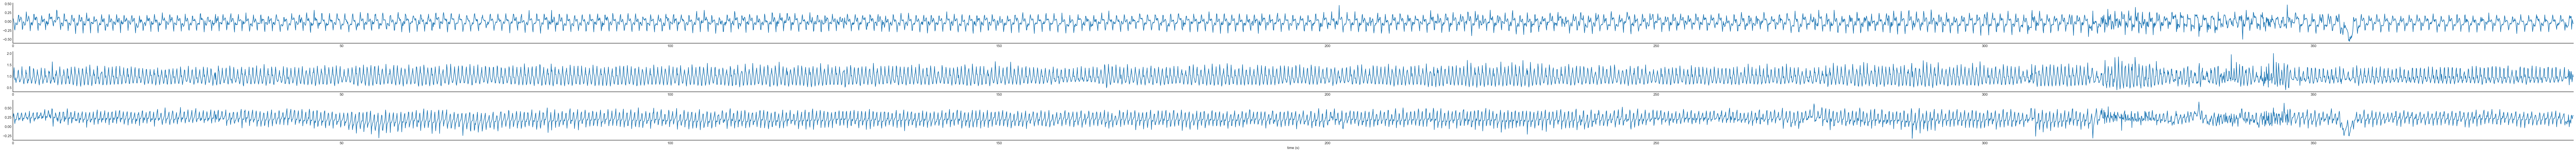

In [64]:
check_walk(df_sync, task_name='Walk 0', outputdir=outputdir_sub, show_plot=False)


In [51]:
# outputdir

In [ ]:
# t_vector.max()-60

In [51]:
# plt.plot(df_sync['VO2_cosmed'])

# add OUES

In [52]:
import sys
epsilon = sys.float_info.epsilon
epsilon

2.220446049250313e-16

In [53]:
# lighting fast! 
@nb.njit(fastmath=True)
def get_slope(X, Y):
    downsample_factor = int(FS_RESAMPLE/5) # respiratory params should be slower than 1Hz
#     downsample_factor = 1 # respiratory params should be slower than 1Hz

    X = X[::downsample_factor]
    Y = Y[::downsample_factor]
    m_x=np.mean(X)
    m_y=np.mean(Y)
    return np.sum((X-m_x)*(Y-m_y))/(np.sum((X-m_x)**2) + epsilon)
#     return np.sum((X-m_x)*(Y-m_y))/np.sum((X-m_x)**2)

def roll_dataframe(df_raw, window, col1, col2, col_new, compute_method):
    df = df_raw.copy()
    df[col_new] = np.nan


    df_start = df[:window//2].iloc[::-1].copy()
    df_end = df[df.shape[0]-window//2:].iloc[::-1].copy()

    df_padded = pd.concat([df_start, df, df_end])
    

    df_padded = df_padded.reset_index(drop=True)
    v_arr = rolling_apply(compute_method, window, df_padded[col1].values, df_padded[col2].values,)

    df_padded.loc[(window-1)//2:df_padded.shape[0]-(window//2)-1, col_new] =  v_arr[window-1:]
    
    df_rolled = df_padded[window//2:df_padded.shape[0]-window//2]
    
    return df_rolled

In [54]:
# %%time
window = int(30*FS_RESAMPLE)
# aaa = roll_dataframe(df_sync[:500*FS_RESAMPLE], window, 'VE_cosmed', 'VO2_cosmed', 'OUES', get_slope)
df_sync = roll_dataframe(df_sync, window, 'VE_cosmed', 'VO2_cosmed', 'OUES_cosmed', get_slope).reset_index(drop=True)


In [55]:
df_sync

,HR_cosmed,RR_cosmed,VT_cosmed,VE_cosmed,FeO2_cosmed,FeCO2_cosmed,FiO2_cosmed,FiCO2_cosmed,VO2_cosmed,VCO2_cosmed,EE_cosmed,SPO2_cosmed,GpsAlt_cosmed,AmbTemp_cosmed,Battery_cosmed,K5_R_cosmed,time,Marker_cosmed,task,Sampled_cosmed,ECG,accelX,accelY,accelZ,ppg_g_1,ppg_r_1,ppg_ir_1,ppg_g_2,ppg_r_2,ppg_ir_2,temp_skin,pres,OUES_cosmed
0,88.198667,15.403947,707.142133,8280.8,16.882280,3.377776,20.93,0.04,289.405867,229.8048,1.395342,95.8,307.0,24.500133,84.0,0.792003,0.004,1.0,Transition,1.0,0.155169,-0.133187,0.945492,0.357531,19397.411083,461.269003,15012.818444,18123.478200,2034.920848,16806.059913,33.336465,981.493709,0.041909
1,88.197333,15.407893,707.084267,8281.6,16.882560,3.377552,20.93,0.04,289.411733,229.8096,1.395371,95.8,307.0,24.500267,84.0,0.792005,0.008,0.0,Transition,0.0,0.153401,-0.129832,0.945292,0.357120,19397.208223,461.162841,15012.672610,18123.137162,2034.813467,16805.878000,33.336425,981.493701,0.041909
2,88.196000,15.411840,707.026400,8282.4,16.882840,3.377328,20.93,0.04,289.417600,229.8144,1.395399,95.8,307.0,24.500400,84.0,0.792008,0.012,0.0,Transition,0.0,0.153067,-0.126078,0.942745,0.353346,19396.948213,461.206246,15013.064674,18123.194942,2034.618145,16805.638406,33.336385,981.493693,0.041909
3,88.194667,15.415787,706.968533,8283.2,16.883120,3.377104,20.93,0.04,289.423467,229.8192,1.395428,95.8,307.0,24.500533,84.0,0.792011,0.016,0.0,Transition,0.0,0.155699,-0.123648,0.939108,0.350225,19396.688203,461.249650,15013.456737,18123.252722,2034.422824,16805.398812,33.336345,981.493685,0.041909
4,88.193333,15.419733,706.910667,8284.0,16.883400,3.376880,20.93,0.04,289.429333,229.8240,1.395456,95.8,307.0,24.500667,84.0,0.792013,0.020,0.0,Transition,0.0,0.153349,-0.123429,0.935549,0.345885,19396.428193,461.293055,15013.848800,18123.310502,2034.227503,16805.159217,33.336305,981.493677,0.041908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161244,110.000000,42.052400,1077.834000,44523.0,18.716280,3.685880,20.93,0.04,643.228000,1295.6400,3.972479,96.0,304.0,21.900000,58.0,2.002280,4644.980,0.0,Recovery 4,0.0,0.077042,-0.085887,0.989743,0.088288,20982.546903,372.819101,17357.243992,15892.944264,2022.267089,11601.293500,33.870000,981.233283,0.012405
1161245,110.000000,42.049920,1077.787200,44518.4,18.716224,3.685904,20.93,0.04,643.182400,1295.5120,3.972157,96.0,304.0,21.900000,58.0,2.002224,4644.984,0.0,Recovery 4,0.0,0.069712,-0.089666,0.989520,0.087894,20984.042816,372.890829,17358.803754,15892.944264,2022.434455,11601.533464,33.870000,981.233291,0.012406
1161246,110.000000,42.047440,1077.740400,44513.8,18.716168,3.685928,20.93,0.04,643.136800,1295.3840,3.971835,96.0,304.0,21.900000,58.0,2.002168,4644.988,0.0,Recovery 4,0.0,0.064080,-0.092322,0.991278,0.090439,20985.538730,372.962557,17360.363516,15892.944264,2022.601821,11601.773427,33.870000,981.233298,0.012406
1161247,110.000000,42.044960,1077.693600,44509.2,18.716112,3.685952,20.93,0.04,643.091200,1295.2560,3.971513,96.0,304.0,21.900000,58.0,2.002112,4644.992,0.0,Recovery 4,0.0,0.060211,-0.092984,0.993911,0.091195,20986.909323,373.140428,17362.041584,15892.902372,2023.058811,11602.110551,33.870000,981.233305,0.012406


<AxesSubplot:xlabel='VE_cosmed', ylabel='EE_cosmed'>

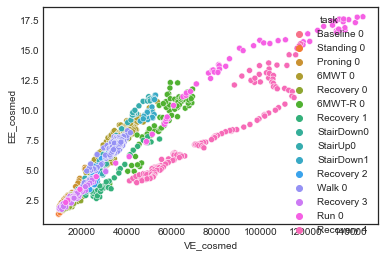

In [56]:
df = df_sync[df_sync['Sampled_cosmed']==1.].copy()
df = df[(df['task']!='Transition') & 
        (df['task']!='SpeakScripted 0') & (df['task']!='SpeakScripted 1') & (df['task']!='SpeakCasual 0') & (df['task']!='SpeakCasual 1') &
         (df['task']!='LL 0') & (df['task']!='LR 0') & (df['task']!='Cough 0') & (df['task']!='Cough 1')
       ].copy()

# import seaborn as sns
# import pandas as pd

# df = pd.read_csv('worldHappiness2016.csv')

sns.scatterplot(data = df, x = "VE_cosmed", y = "EE_cosmed", hue='task')

# plt.show()

# plot the signals

In [57]:
Fs = FS_RESAMPLE

In [58]:
def stage2_get_filt_df(df_sync, Fs):

    df = df_sync.copy()

#     Fs = FS_RESAMPLE
    # lowcutoff = 0.8
    # highcutoff = 8

    df['ECG'] = get_padded_filt(df['ECG'].values, filter_padded=5, lowcutoff=FILT_ECG[0], highcutoff=FILT_ECG[1], Fs=Fs)

    df['ppg_ir_1'] = -get_padded_filt(df['ppg_ir_1'].values, filter_padded=5, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=Fs)
    df['ppg_r_1'] = -get_padded_filt(df['ppg_r_1'].values, filter_padded=5, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=Fs)
    df['ppg_g_1'] = -get_padded_filt(df['ppg_g_1'].values, filter_padded=5, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=Fs)
    df['ppg_ir_2'] = -get_padded_filt(df['ppg_ir_2'].values, filter_padded=5, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=Fs)
    df['ppg_r_2'] = -get_padded_filt(df['ppg_r_2'].values, filter_padded=5, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=Fs)
    df['ppg_g_2'] = -get_padded_filt(df['ppg_g_2'].values, filter_padded=5, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=Fs)
    
    return df


In [59]:
# define range
t_start = 0
t_end = df_sync[df_sync['task']=='Recovery 4']['time'].max()

# get a copy of data in this range
# df = get_filt_df(df_sync, Fs).copy()
df = stage2_get_filt_df(df_sync, Fs).copy()
df = df[(df['time'] >= t_start) & (df['time'] <= t_end)]

# downsample it to make plotting quicker
downsample_factor = 1
df = df[df.index%downsample_factor==0]

# plot the signals
plt_scale = 1.2




start_task = df[df['task'].str.contains("6MWT", case=False)]['task'].unique()[0]
end_task = 'Run 0'

t_start = df[df['task']==start_task]['time'].min()
t_end = df[df['task']==end_task]['time'].max()
t_start, t_end

fig_name = '6MWT2Run_{}s'.format(int(t_end-t_start))

plot_all_sync(df, subject_id,plt_scale=plt_scale, outputdir=outputdir_sub, fig_name=fig_name, show_plot=False)


# save the data

In [60]:
if saving_format=='csv':
    df_sync.to_csv(outputdir_sub+'df_sync.'+saving_format, index=False)
elif saving_format=='feather':
    df_sync.to_feather(outputdir_sub+'df_sync.'+saving_format)

    




# 4 sub 

In [61]:
export_4sub = False

if export_4sub:

    df_sub = df_sync[['time', 'HR_cosmed',	'VT_cosmed',	'VE_cosmed',	'VO2_cosmed',	'VCO2_cosmed',	'EE_cosmed',	'SPO2_cosmed',	'AmbTemp_cosmed',	'Sampled_cosmed', 'task']].copy()
    df_sub = df_sub[df_sub['Sampled_cosmed']==1]

#     df_sub.to_csv(outputdir_sub+'df_4sub.csv')
#     plt.plot(df_sub['time'], df_sub['VT_cosmed'])